### Portfolio: Walmart Weekly Sales Forecast - Exploratory Data Analysis ###

**Problem Statement:** You are provided with historical sales data for 45 Walmart stores located in different regions. Each store contains several departments, and you are tasked with predicting the department-wide sales for each store. In addition, Walmart runs several promotional markdown events throughout the year. These markdowns precede prominent holidays, the four largest of which are the Super Bowl, Labor Day, Thanksgiving, and Christmas. The weeks including these holidays are weighted five times higher in the evaluation than non-holiday weeks. Part of the challenge presented by this competition is modeling the effects of markdowns on these holiday weeks in the absence of complete/ideal historical data.

**Stakeholders:** 
1. Walmart store managers
2. Regional operational directors
3. Data science team

## Part A. Import Cleaned Dataset ##

In [1]:
# Import all libraries #
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import csv
from sklearn.utils import shuffle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# Authorization #
__author__ = "Taesun Yoo"
__email__ = "yoots1988@gmail.com"

In [2]:
# --- 1. Write Out List of Functions --- #
def load_file(file):
    '''load input CSVs as a dataframe'''
    return pd.read_csv(file, encoding='latin1')


def create_list_vars(df, dt_type):
    '''create a list of variables '''
    list_vars = list(df.select_dtypes(include=dt_type))
    return list_vars


def join_data(df1, df2, join_type, key=None,
              left_index=None, right_index=None):
    '''merge the dataframes by a key'''
    df_join = pd.merge(df1, df2, how=join_type, on=key,
                       left_index=False, right_index=False)
    return df_join


def drop_column(df, var_name):
    ''' drop a column on dataframe '''
    df = df.drop(var_name, axis=1)
    return df


def convert_dt_as_date(df, var_name, date_format):
    '''convert the variable as specified date format'''
    df[var_name] = pd.to_datetime(df[var_name], format=date_format)
    return df[var_name]


def convert_dt_as_custom(df, var_name, dt_type):
    '''convert datatype on selected variables'''
    df[var_name] = df[var_name].astype(dt_type)
    return df[var_name]


def convert_dt_to_cat(df):
    '''convert data type to category'''
    for col in df.columns:
        if df[col].dtype.name == 'object':
            df[col] = df[col].astype('category')


def gen_unique_id(df, var_1, var_2, var_3):
    '''generate unique id for each sales transactions'''
    df['trans_id'] = df[var_1].map(str)+'_'+df[var_2].map(str)+'_'+df[var_3].map(str)
    return df['trans_id']


def eda_encode_cat_var(df, col, num_var):
    '''encode the cat. variables by mean of a num. variable by each cat'''
    cat_dict={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat][num_var].mean()
    df[col] = df[col].map(cat_dict)


def estimate_width(df, var_name, interval_size):
    ''' estimate the width of continuous variable '''
    width = (max(df[var_name]) - min(df[var_name]))/interval_size
    df_estimate = pd.DataFrame([[min(df[var_name])-1, max(df[var_name])+1, round(width)]])
    df_estimate.columns = ['min', 'max', 'width']
    return df_estimate


def pandas_cut(df, new_var, old_var, bins, labels=None):
    ''' apply pd.cut for custom size binning '''
    df[new_var] = pd.cut(df[old_var], bins=bins, 
                          labels=labels, right=False)
    return df[new_var]


def check_value_counts(df, var_name):
    '''return grouped value counts'''
    grouped_counts = df[var_name].value_counts()
    return grouped_counts

def feature_replacement(df):
    '''impute missing values based on specific data type and a column'''
    for column in df.columns:
        if df[column].dtype.name == 'object':
            mode = df[column].mode().iloc[0]
            df[column] = df[column].fillna(mode)
        elif df[column].dtype.name == 'float64':
            mean = df[column].mean()
            df[column] = df[column].fillna(mean)
        elif df[column].dtype.name == 'datetime64[ns]':
            pseudo_date = pd.Timestamp.max
            df[column] = df[column].fillna(pseudo_date)
        else:
            md_cols = df.columns[df.columns.str.contains(pat = 'MarkDown')]
            df[md_cols] = df[md_cols].fillna(0)
            

def eda_missing(df):
    '''compute missing % on each var'''
    df_missing = pd.DataFrame(df.isnull().sum(), columns=['count'])
    df_missing['pct'] = (df_missing['count']/len(df)) * 100
    return df_missing


def eda_stat_num(df):
    ''' perform eda for numerical features '''
    df_stat_num = df.describe().T
    df_stat_num = df_stat_num[['count', 'min', 'mean', 'max', 'std', '25%', '50%', '75%']]
    df_stat_num = pd.DataFrame(df_stat_num)
    return df_stat_num


def eda_stat_cat(df):
    ''' perform eda for categorical features '''
    df_stat_cat = df.describe(include='O').T
    df_stat_cat = pd.DataFrame(df_stat_cat)
    return df_stat_cat


def eda_outliers(df):
    '''check outliers using the IQR method'''
    df['IQR'] = df['75%'] - df['25%']
    df['LB']  = df['25%'] - 1.5*df['IQR']
    df['UB']  = df['75%'] + 1.5*df['IQR']
    df = df.drop(['count','std','mean','25%','50%','75%','IQR'], axis=1)
    return df


def eda_agg_df_var(df, cat_var, kpi_dict):
    '''compute aggregated dataframe to calculate the KPIs'''
    df_agg = df.groupby(by=cat_var).agg(kpi_dict)
    return df_agg


def eda_grouped_df_var(df, cat_var):
    '''create a grouped dataframe by categorical variable'''
    df_grp = pd.DataFrame(df.groupby([cat_var])[cat_var].count())
    df_grp.columns = ['count']
    return df_grp


def plot_hist(df, var_1, color):
    '''plot a histogram'''
    plt.figure()
    print("skenewss is:", df[var_1].skew())
    df[var_1].hist(color=color)
    plt.title('Histogram of ' + var_1)
    plt.xlabel(var_1)
    plt.ylabel('transactions')
    plt.show()


def plot_bar_chart(df, var_name_1):
    '''plot a bar chart'''
    plt.figure(figsize=(10,10))
    var_count_1 = df[var_name_1].value_counts()
    sns.barplot(var_count_1.index,  var_count_1.values, order=var_count_1.index, alpha=0.9)
    plt.title('Frequency chart of ' + var_name_1)
    plt.ylabel('transactions')
    plt.xlabel(var_name_1)
    plt.xticks(rotation=270)
    plt.show()

    
def plot_freq_chart(x,y,df,order):
    '''plot a frequency chart'''
    plt.figure(figsize=(8,8))
    sns.countplot(x=x, hue=y, data=df, order=order)
    plt.title('Bar chart: ' + x + ' of type  labels', fontsize=20)
    plt.xticks(rotation=270, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(x, fontsize=12)
    plt.ylabel('transactions', fontsize=12)
    plt.legend(loc='upper right', fontsize=20)
    plt.show()


def plot_pie_chart(df_1, var_name_1,
                   df_2, var_name_2):
    '''plot a pie chart of specified variables'''
    plt.figure(figsize=(15,15))
    # Sub-plot 1:
    plt.subplot(1,2,1)
    plt.pie(df_1, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_1)
    plt.legend(labels = df_1.index, loc='upper right')
    # Sub-plot 2:
    plt.subplot(1,2,2)
    plt.pie(df_2, autopct='%.0f%%', wedgeprops={'edgecolor':'white'},
            textprops={'fontsize':15})
    plt.title('Pie Chart of '+ var_name_2)
    plt.legend(labels = df_2.index, loc='upper right')
    plt.show()
    

def plot_box(df, num_var_1, cat_var_1,
             num_var_2, cat_var_2, 
             num_var_3, cat_var_3, hue=None):
    '''plot a box-whisker of specified variables'''
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    # Sub-plot 1:
    plt.subplot(1,3,1)
    df.sort_values(by=[num_var_1], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_1, num_var_1, hue, df)
    plt.title('Box plot of ' + num_var_1 + ' by ' + cat_var_1)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 2:
    plt.subplot(1,3,2)
    df.sort_values(by=[num_var_2], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_2, num_var_2, hue, df)
    plt.title('Box plot of ' + num_var_2 + ' by ' + cat_var_2)
    plt.xticks(rotation=270, fontsize=10)
    # Sub-plot 3:
    plt.subplot(1,3,3)
    df.sort_values(by=[num_var_3], inplace=True)
    sns.set(style='whitegrid')
    sns.boxplot(cat_var_3, num_var_3, hue, df)
    plt.title('Box plot of ' + num_var_3 + ' by ' + cat_var_3)
    plt.xticks(rotation=270, fontsize=10)    

    
def plot_crosstab(df, cat_var_1, cat_var_2):
    '''plot a crosstab of two categorical variables'''
    table = pd.crosstab(df[cat_var_1], df[cat_var_2])
    return table


def plot_corr_matrix(df, list_vars):
    ''' plot a correlation matrix '''
    corr = df[list_vars].corr()
    # Create a mask
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(corr)] = True
    plt.figure(figsize=(12,12))
    sns.heatmap(corr, mask=mask, square=True, linewidths = .5,
                cmap=sns.diverging_palette(220,10,as_cmap=True),
                vmin = -1, vmax = 1, fmt=".2f",
                annot=True, annot_kws={'size':11})
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()


def plot_scatter(df, var_1, var_2, color, factor=None):
    '''Scatter plot of two continuous numeric features'''
    plt.figure(figsize=(8,8))
    plt.scatter(df[var_1]*factor, df[var_2], color=color)
    plt.title('Relationship between '+ var_1 + ' and ' + var_2)
    plt.xlabel(var_1)
    plt.ylabel(var_2)
    plt.show()

    
def compute_pearson_r(df, var_x, var_y):
    '''compute Pearson r correlation'''
    corr_mat = np.corrcoef(df[var_x],df[var_y])
    return corr_mat[0, 1]


def plot_linear_reg(df, var_x, var_y, 
                    pearson_r, color, label):
    '''plot a pair of linear regressions'''
    plt.figure(figsize=(10,10))
    plt.plot(df[var_x], df[var_y], 'r--', label='pearson_r =%.2f' % pearson_r,
             marker='.', linestyle='none', color=color)
    plt.margins(0.02)
    plt.legend(loc='upper left')
    plt.xlabel(var_x)
    plt.ylabel(var_y)
    plt.title(var_x + ' vs. ' + var_y + ' by ' + label)
    # Fit linear regression:
    a,b = np.polyfit(df[var_x], df[var_y], 1)
    x = np.array([min(df[var_x]), max(df[var_x])])
    y = a*x + b
    plt.plot(x,y)

In [3]:
# --- 2. Load the data --- #
if __name__ == '__main__':
    train_data = 'sales_train.csv'
    store_data = 'sales_stores.csv'
    feature_data = 'sales_features.csv'

# Load data
df_eda = load_file(train_data)
df_store = load_file(store_data)
df_feature = load_file(feature_data)

# re-order columns on df_train:
list_order = ['Store','Dept','Date','IsHoliday','Weekly_Sales']
df_eda = df_eda[list_order]

# --- 3. ETL - metadata format --- #
# left joins on feature and store data:
list_key_1 = 'Store'
df_dimension = join_data(df_feature, df_store, 'left', list_key_1)

# left joins on df_dimension and df_walmart_sales:
list_key_2 = ['Store', 'Date', 'IsHoliday']
df_eda = join_data(df_eda, df_dimension, 'left', list_key_2)
# delete keys and dataframes:
del(df_dimension, df_feature, df_store)
del(list_key_1, list_key_2)

In [4]:
# --- 4. Feature Engineering --- #
# convert temperature "Fahrenheit" to "Celcius":
df_eda['Temperature'] = (df_eda['Temperature'] - 32) * 5/9

# format date as follow:
date_format = '%Y-%m-%d'
df_eda['Date'] = pd.to_datetime(df_eda['Date'])

# Create a variable: dummy holiday type:
holiday_type = ['Superbowl', 'Labor_Day', 'Thanksgiving', 'Black_Friday', 'Christmas_Eves']

# adjustments based on Walmart weekly transaction date:
conditions = [(df_eda['Date']=='2010-2-12') | # 2010/02/05 + 7 days
        (df_eda['Date']=='2011-2-11') |   # 2011/02/04 + 7 days
        (df_eda['Date']=='2012-2-3'),    # 2012/02/03 + 0 days
        (df_eda['Date']=='2010-9-10') |   # 2010/09/06 + 4 days 
        (df_eda['Date']=='2011-9-9') |   # 2011/09/05 + 4 days
        (df_eda['Date']=='2012-9-7'),    # 2012/09/03 + 0 days
        (df_eda['Date']=='2010-10-15') | # 2010/10/11 + 4 days
        (df_eda['Date']=='2011-10-14') | # 2011/10/10 + 4 days
        (df_eda['Date']=='2012-10-5'),   # 2012/10/08 + 0 days
        (df_eda['Date']=='2010-11-26') | # 2010/11/26 + 0 days
        (df_eda['Date']=='2011-11-25'),  # 2011/11/25 + 0 days
        (df_eda['Date']=='2010-12-24') | # 2010/12/24 + 0 days
        (df_eda['Date']=='2011-12-23') ] # 2011/12/23 + 0 days
    
df_eda['Holiday_Type'] = np.select(conditions, holiday_type, default='non-holidays')

# check data type:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   IsHoliday     421570 non-null  bool          
 4   Weekly_Sales  421570 non-null  float64       
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  object        
 15  Size          421

In [5]:
# --- 5. ETL - merging/subsetting data --- #
# define variables:
var_label = 'Weekly_Sales'
var_id_1 = 'Store'
var_id_2 = 'Dept'
var_id_3 = 'Date'
list_id_vars = [var_id_1, var_id_2, var_id_3]

vars_num_disc = create_list_vars(df_eda, 'int64') 
vars_num_cont = create_list_vars(df_eda, 'float64')

# concatenate the two lists:
vars_num = vars_num_disc + vars_num_cont

list_unwanted = {'Store','Dept'}

vars_num = [item for item in vars_num if item not in list_unwanted]

del(vars_num_disc, vars_num_cont)

## Part B. Exploratory Data Analysis ##

#### Dataset Name: Training Set ###
Data exploration is conducted on a cleaned training set. The main goal of this phase is to explore any interesting relationships among features and identify which features are good predictors on poverty rate predictions.

Following set of questions are asked:
1. Can I count something interesting?
2. Can I find some trends (increase or decrease and any anomalies)?
3. Can I plot a bar chart or a histogram?
4. Can I make a scatter plot?

These set of guiding questions will help us to explore any insights and tell a compelling story about the US poverty dataset.

In [6]:
# compute top 10 rows:
df_eda.head(10)

# check any duplicates
df_eda.duplicated().sum()

0

In [7]:
# create a missing % dataframe: before
df_missing_pre = eda_missing(df_eda)
df_missing_pre

,count,pct
Store,0,0.000000
Dept,0,0.000000
Date,0,0.000000
IsHoliday,0,0.000000
Weekly_Sales,0,0.000000
Temperature,0,0.000000
Fuel_Price,0,0.000000
MarkDown1,270889,64.257181
MarkDown2,310322,73.611025
MarkDown3,284479,67.480845


In [8]:
# feature replacement:
feature_replacement(df_eda)

In [9]:
# create a missing % dataframe: after
df_missing_post = eda_missing(df_eda)
df_missing_post

,count,pct
Store,0,0.0
Dept,0,0.0
Date,0,0.0
IsHoliday,0,0.0
Weekly_Sales,0,0.0
Temperature,0,0.0
Fuel_Price,0,0.0
MarkDown1,0,0.0
MarkDown2,0,0.0
MarkDown3,0,0.0


In [10]:
# ---3 perform summary statistics ---
# convert data type: store and dept as object
convert_dt_as_custom(df_eda, 'Store', 'object')
convert_dt_as_custom(df_eda, 'Dept', 'object')

# create a list: categorical variables
vars_cat = create_list_vars(df_eda, 'object')

In [11]:
# numerical features:
df_stat_num = eda_stat_num(df_eda[vars_num])
df_stat_num

,count,min,mean,max,std,25%,50%,75%
Size,421570.0,34875.000000,136727.915739,219622.000000,60980.583328,93638.000000,140167.000000,202505.000000
Weekly_Sales,421570.0,-4988.940000,15981.258123,693099.360000,22711.183519,2079.650000,7612.030000,20205.852500
Temperature,421570.0,-18.922222,15.605588,37.855556,10.248851,8.155556,16.716667,23.488889
Fuel_Price,421570.0,2.472000,3.361027,4.468000,0.458515,2.933000,3.452000,3.738000
MarkDown1,421570.0,0.000000,2590.074819,88646.760000,6052.385934,0.000000,0.000000,2809.050000
MarkDown2,421570.0,-265.760000,879.974298,104519.540000,5084.538801,0.000000,0.000000,2.200000
MarkDown3,421570.0,-29.100000,468.087665,141630.610000,5528.873453,0.000000,0.000000,4.540000
MarkDown4,421570.0,0.000000,1083.132268,67474.850000,3894.529945,0.000000,0.000000,425.290000
MarkDown5,421570.0,0.000000,1662.772385,108519.280000,4207.629321,0.000000,0.000000,2168.040000
CPI,421570.0,126.064000,171.201947,227.232807,39.159276,132.022667,182.318780,212.416993


In [12]:
# categorical features:
df_stat_cat = eda_stat_cat(df_eda[vars_cat])
df_stat_cat

,count,unique,top,freq
Store,421570,45,13,10474
Dept,421570,81,1,6435
Type,421570,3,A,215478
Holiday_Type,421570,6,non-holidays,383044


In [13]:
# ---4 detect outliers ---
# create a dataframe for IQR:
df_outliers = eda_outliers(df_stat_num)
df_outliers

,min,max,LB,UB
Size,34875.000000,219622.000000,-69662.500000,365805.500000
Weekly_Sales,-4988.940000,693099.360000,-25109.653750,47395.156250
Temperature,-18.922222,37.855556,-14.844444,46.488889
Fuel_Price,2.472000,4.468000,1.725500,4.945500
MarkDown1,0.000000,88646.760000,-4213.575000,7022.625000
MarkDown2,-265.760000,104519.540000,-3.300000,5.500000
MarkDown3,-29.100000,141630.610000,-6.810000,11.350000
MarkDown4,0.000000,67474.850000,-637.935000,1063.225000
MarkDown5,0.000000,108519.280000,-3252.060000,5420.100000
CPI,126.064000,227.232807,11.431178,333.008482


In [14]:
# check outliers:
# lower bounds (LBs)
df_eda[df_eda.Temperature < 5.28]

,Store,Dept,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Holiday_Type
1,1,1,2010-02-12,True,46039.49,3.616667,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315,Superbowl
2,1,1,2010-02-19,False,41595.55,4.405556,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315,non-holidays
49,1,1,2011-01-14,False,17359.70,1.888889,2.983,0.00,0.00,0.00,0.00,0.00,211.457411,7.742,A,151315,non-holidays
53,1,1,2011-02-11,True,37887.17,2.438889,3.022,0.00,0.00,0.00,0.00,0.00,212.936705,7.742,A,151315,Superbowl
144,1,2,2010-02-12,True,44682.74,3.616667,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315,Superbowl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421528,45,98,2012-01-13,False,677.71,5.100000,3.513,3489.73,11219.72,0.92,489.07,9596.29,189.326096,8.424,B,118221,non-holidays
421529,45,98,2012-01-20,False,848.84,-0.083333,3.533,3205.90,4038.51,2.19,488.63,2344.09,189.421473,8.424,B,118221,non-holidays
421530,45,98,2012-01-27,False,671.40,3.294444,3.567,1890.49,2618.49,0.00,139.07,5692.74,189.516850,8.424,B,118221,non-holidays
421532,45,98,2012-02-10,True,770.86,2.777778,3.640,15760.30,6113.95,5.43,5656.35,4685.58,189.707605,8.424,B,118221,non-holidays


In [15]:
# upper bounds (UBs)
df_eda[df_eda.Weekly_Sales > 47395]

,Store,Dept,Date,IsHoliday,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Holiday_Type
8,1,1,2010-04-02,False,57258.43,16.816667,2.719,0.00,0.00,0.00,0.00,0.00,210.820450,7.808,A,151315,non-holidays
46,1,1,2010-12-24,False,55931.23,11.294444,2.886,0.00,0.00,0.00,0.00,0.00,211.405122,7.838,A,151315,Christmas_Eves
63,1,1,2011-04-22,False,50510.31,22.772222,3.807,0.00,0.00,0.00,0.00,0.00,215.459905,7.682,A,151315,non-holidays
106,1,1,2012-02-17,False,54060.10,7.400000,3.510,9873.33,11062.27,9.80,8409.31,3402.66,220.425759,7.348,A,151315,non-holidays
113,1,1,2012-04-06,False,57592.12,21.350000,3.891,10121.97,0.00,77.98,3750.59,4510.72,221.435611,7.143,A,151315,non-holidays
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421285,45,95,2012-09-28,False,49380.11,18.266667,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,non-holidays
421286,45,95,2012-10-05,False,50241.01,18.272222,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221,Thanksgiving
421287,45,95,2012-10-12,False,49334.77,12.483333,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221,non-holidays
421288,45,95,2012-10-19,False,48434.97,13.594444,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221,non-holidays


## Summarize DataFrames by KPIs ##

In [16]:
# create a id column:
gen_unique_id(df_eda, 'Store', 'Dept', 'Date')

# Define the dictionary for KPIs:
kpi_dict = {'trans_id':'nunique', 'Temperature':'mean', 'CPI':'mean', 
            'Fuel_Price':'mean', 'Unemployment':'mean', 'Weekly_Sales':'mean'}

# ---5 aggregate dataframe and compute KPIs ---
# Summarize a dataframe by Store ID:
df_agg_store = eda_agg_df_var(df_eda, 'Store', kpi_dict)

df_agg_store['Sales_Per_Transactions'] = df_agg_store.Weekly_Sales/df_agg_store.trans_id

df_agg_store = df_agg_store.sort_values(by='Sales_Per_Transactions', ascending=False)

# Print a summary KPI table by Store:
df_agg_store.rename_axis('Store')

,trans_id,Temperature,CPI,Fuel_Price,Unemployment,Weekly_Sales,Sales_Per_Transactions
Store,,,,,,,
20,10214,12.973064,209.047863,3.418723,7.370847,29508.301592,2.889005
14,10040,14.328772,186.287850,3.417702,8.649212,28784.851727,2.867017
4,10272,16.764926,128.680070,3.216237,5.965849,29161.210415,2.838903
2,10238,20.058575,215.651869,3.219898,7.623279,26898.070031,2.627278
13,10474,12.001693,128.674214,3.284581,7.004905,27355.136891,2.611718
10,10315,22.304351,128.664162,3.572490,8.371005,26332.303819,2.552817
27,10225,14.061464,139.017071,3.579829,8.001492,24826.984536,2.428067
6,10211,20.911075,217.564946,3.220977,6.606213,21913.243624,2.146043
39,9878,21.437505,214.723962,3.219481,7.869865,21000.763562,2.126014


In [17]:
# Summarize a dataframe by hoilday type:
df_agg_holiday_type = eda_agg_df_var(df_eda, 'Holiday_Type', kpi_dict)

df_agg_holiday_type['Sales_Per_Transactions'] = df_agg_holiday_type.Weekly_Sales/df_agg_holiday_type.trans_id

df_agg_holiday_type = df_agg_holiday_type.sort_values(by='Sales_Per_Transactions', ascending=False)

# Print a summary KPI table by Store:
df_agg_holiday_type.rename_axis('Holiday_Type')

,trans_id,Temperature,CPI,Fuel_Price,Unemployment,Weekly_Sales,Sales_Per_Transactions
Holiday_Type,,,,,,,
Christmas_Eves,5983,4.302214,170.921616,3.159811,8.094594,26396.399283,4.411900
Black_Friday,5959,9.021891,170.734578,3.180768,8.090002,22220.944538,3.728972
Superbowl,8871,2.426876,170.230721,3.105149,8.094789,15979.988559,1.801374
Labor_Day,8861,23.425783,171.732949,3.417864,7.884881,15881.693339,1.792314
Thanksgiving,8852,17.106542,172.301468,3.393749,7.702866,15261.063382,1.724024
non-holidays,383044,15.974182,171.198396,3.370829,7.960751,15740.483144,0.041093


## Summary: Holiday Type ##
1. Mean weekly sales is the highest in Christmas Eves followed by Black Friday, Superbowl, Labor Day and etc.
2. Although mean unemployment rate is the highest in Christmas Eves, a lot of people spend their money on purchasing gifts.

### Uni-variate: Histograms ###

skenewss is: -0.10490149562840599


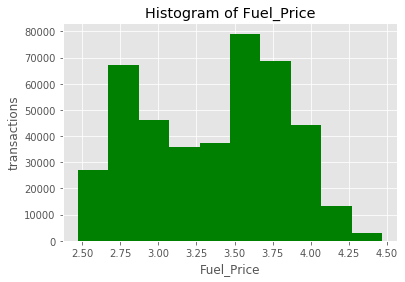

skenewss is: -0.3214041519699791


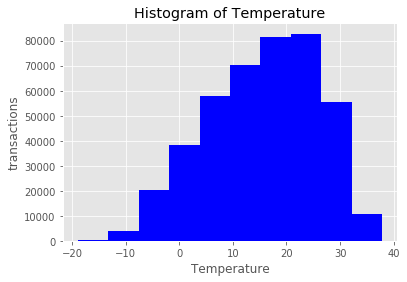

skenewss is: 0.08521928473260015


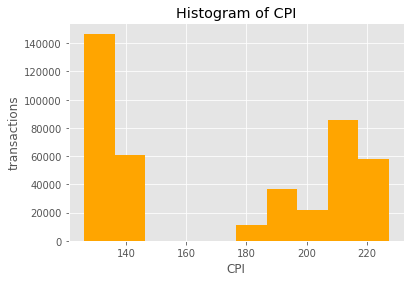

skenewss is: 1.1837425684974316


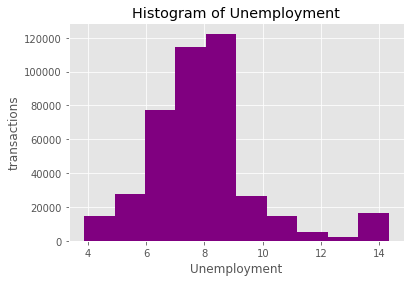

In [18]:
# ---6 visualize data: uni-variate ---
# plot a histogram:    
plot_hist(df_eda, 'Fuel_Price', 'green')

plot_hist(df_eda, 'Temperature', 'blue')

plot_hist(df_eda, 'CPI', 'orange')

plot_hist(df_eda, 'Unemployment', 'purple')

### Summary: Histograms ###
1. Fuel Price: showed distribution skewed to left. Majority of weekly transactions occurred at 3.5 USD/Gallon.
2. Temperature: showed distribution is not quite normal. Majority of weekly transactions occurred over 10 degree Celcius.
3. Consumer Price Index: showed distribution skewed to right. Majority of weekly transactions occurred below the CPI 140.
4. Unemployment: showed distribution skewed to right. Majority of weekly transactions occurred around 8%.

### Uni-variate: Bar Charts ###

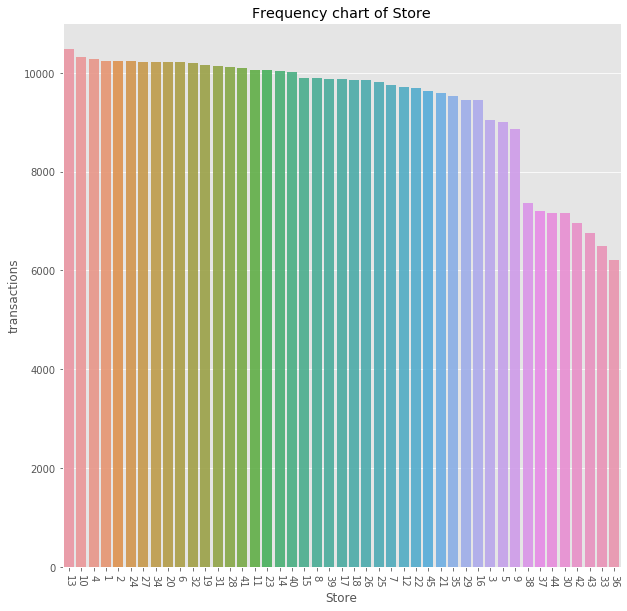

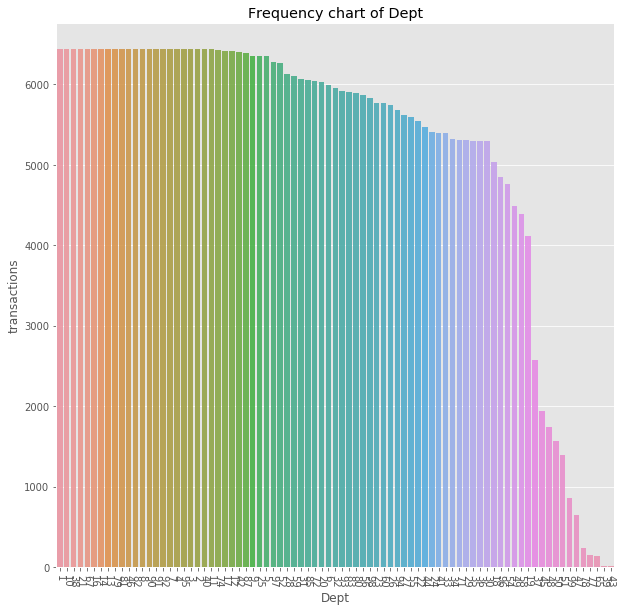

In [19]:
# plot a bar chart:
plot_bar_chart(df_eda, 'Store')

plot_bar_chart(df_eda, 'Dept')

### Summary: Bar Charts ###
1. Store: many stores have sales close 10,000 transactions with exception of few stores around 6,000 (i.e., store 33, 36 and 43.)

2. Department: many departments have sales over 6,000 transactions. However, there are few departments where transactions are less than a few hundreds (i.e., Department 43, 39, 65, and etc.) 

### Uni-variate: Pie Charts ###

C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:185: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
C:\Users\yoots\Anaconda3\lib\site-packages\ipykernel_launcher.py:191: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.


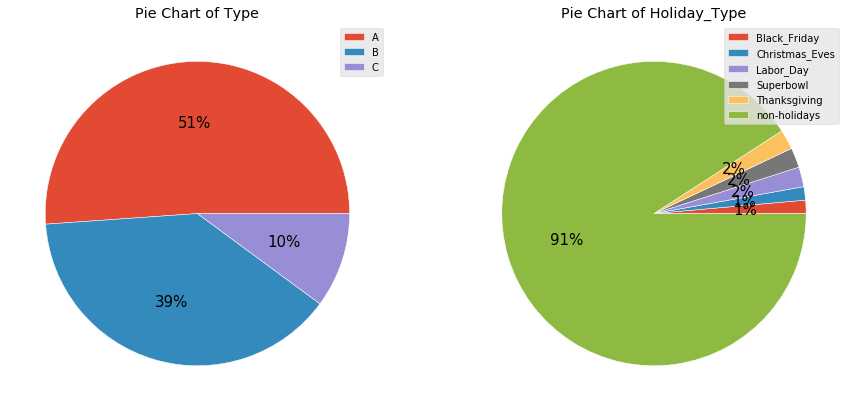

In [20]:
# grouped dataframe by a categorical feature:
df_grp_type = eda_grouped_df_var(df_eda, 'Type')
df_grp_holiday_type = eda_grouped_df_var(df_eda, 'Holiday_Type')

# Plot pie chart(s) by categorical features:
plot_pie_chart(df_grp_type, 'Type',
              df_grp_holiday_type, 'Holiday_Type')

### Summary: Pie Charts ###
1. Store Type: majority of sales by Walmart store type is A (51%) follow by B (39%) and C (10%).
2. Holiday Type: majority of sales occur in weekdays (91%) followed by Superbowl, Thanksgiving and Labor Day.

### Bi-vairate: Box-Whisker Plots ###

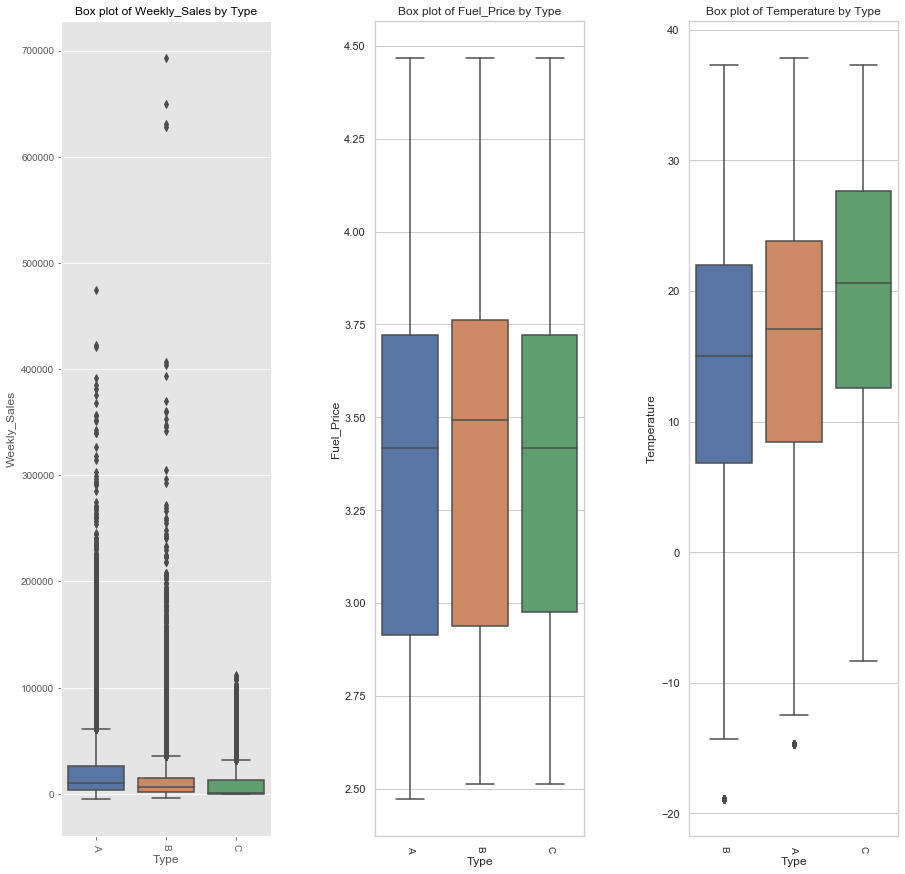

In [21]:
plot_box(df_eda, 'Weekly_Sales', 'Type',
        'Fuel_Price', 'Type',
        'Temperature', 'Type')

### Summary: Box-Whisker Plots 1 ###
1. Weekly Sales by Store Type: mean weekly sales is the highest in type "A" and the lowest in Type "C".

2. Fuel Price by Store Type: mean fuel price is the highest in type "B" whereas "A" and "C" are very close (below 3.5 USD/Gallon).

3. Temperature by Store Type: mean temperature is the highest in type "C" and the lowest in Type "B"

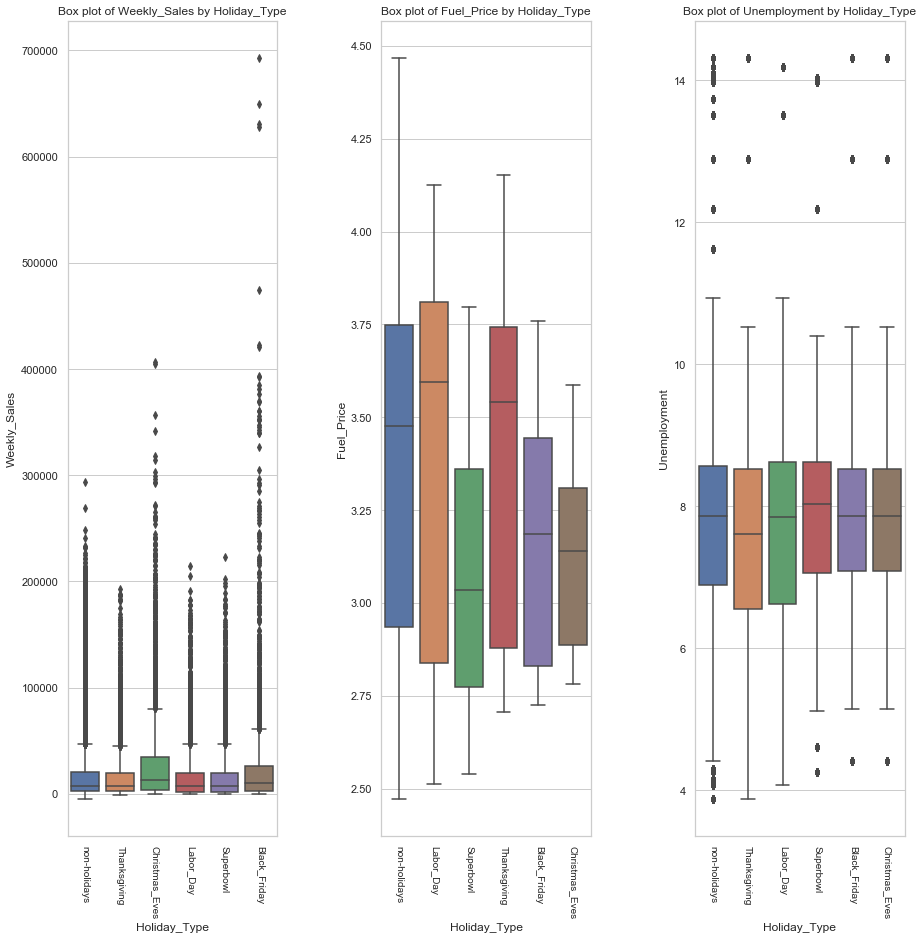

In [22]:
plot_box(df_eda, 'Weekly_Sales', 'Holiday_Type',
        'Fuel_Price', 'Holiday_Type',
        'Unemployment', 'Holiday_Type')

### Summary: Box-Whisker Plots 2 ###
1. Weekly Sales by Holiday Type: mean weekly sales is the highest in Christmas Eves and the lowest in weekdays.

2. Fuel Price by Holiday Type: mean fuel price is the highest in Labor Day and followed by weekdays and etc.

3. Unemployment Rate by Holiday Type: mean unemployment rate is the highest in early years (i.e., Superbowl Season).

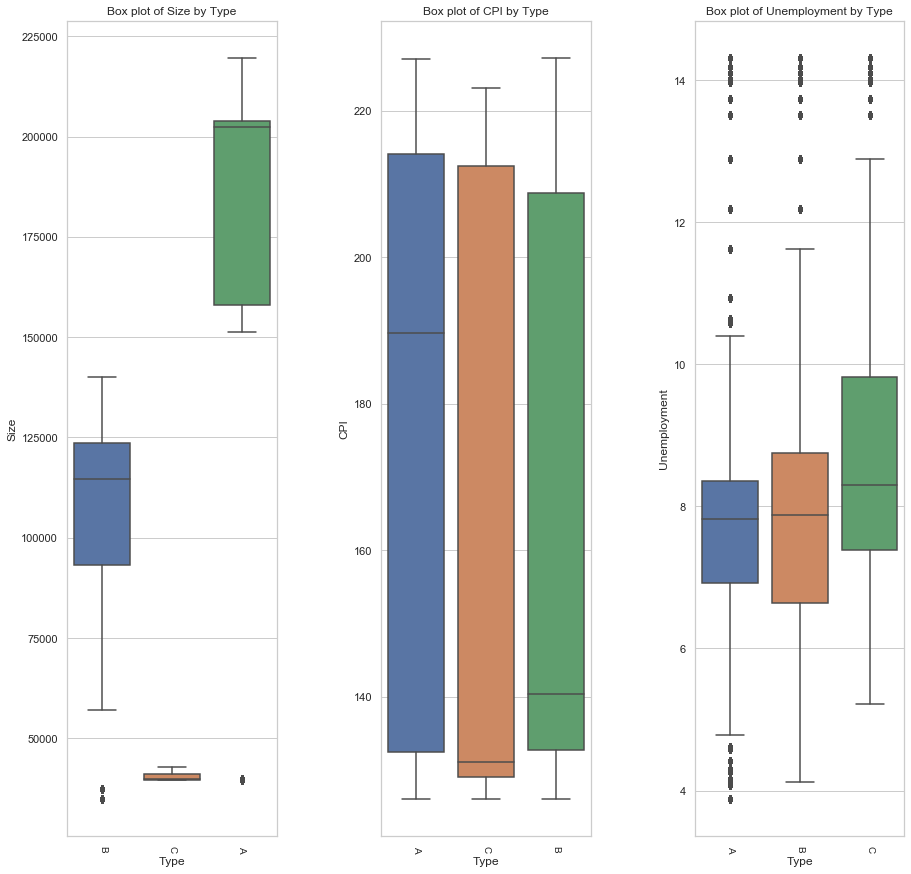

In [23]:
plot_box(df_eda, 'Size', 'Type',
        'CPI', 'Type',
        'Unemployment', 'Type')

### Summary: Box-Whisker Plots 3 ###
1. Size by Store Type: mean store size is the largest in type "A" and the smallest in type "B".

2. CPI by Store Type: mean CPI is the highest in type "A" and the lowest in type "C".

3. Unemployment % by Store Type: mean unemployment is the highest in type "C" and the lowest in Type "A"

### Bi-variate: Correlation Matrix ###

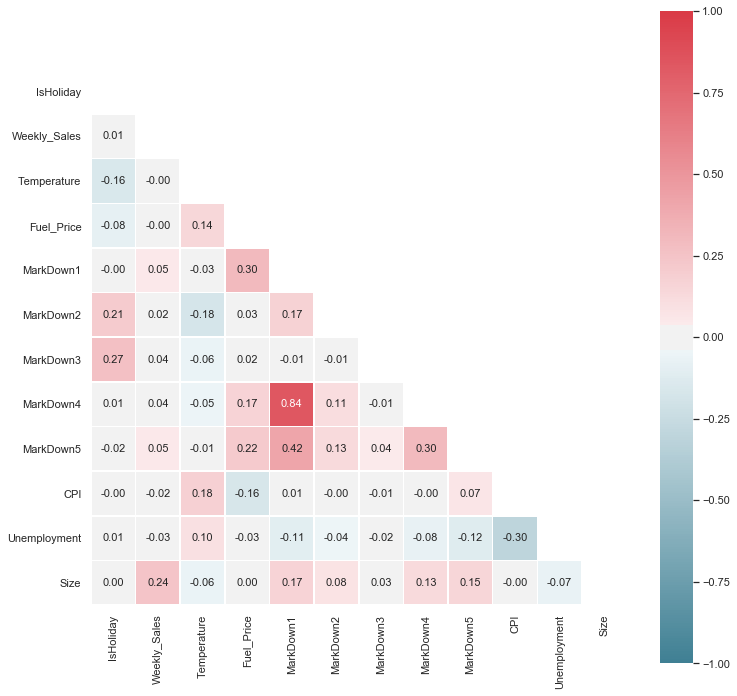

In [24]:
# create a dataframe:
df_eda_cm = df_eda.copy()

# drop columns: Store, Dept
df_eda_cm = drop_column(df_eda_cm, ['Date', 'trans_id', 'Type', 'Store', 'Dept'])

# convert data type: object to category
convert_dt_to_cat(df_eda_cm)

# encode categorical variables using Weekly_Sales:
for col in df_eda_cm.columns:
    if df_eda_cm[col].dtype.name == 'category':
        eda_encode_cat_var(df_eda_cm, col, 'Weekly_Sales')

# Create a list of variables:
vars_list = list(df_eda_cm.columns)

# Delete a list of unwanted variables:
unwanted_list = {'Date', 'trans_id', 'Type'}

vars_list = [item for item in vars_list if item not in unwanted_list]

# plot a correlation matrix:
plot_corr_matrix(df_eda_cm, vars_list)

### Summary: Correlation Matrix ###
From above plot, we can conclude that Size is the strongest feature that postively correlates with Weekly Sales (r=0.24). The least correlated feature is the MarkDown2.

Interest relationships to note here with respect to the magnitude of Pearson correlation (r):
1. MarkDown1 and MarkDown4: have a strong postive correlation (r=0.79)
2. MarkDown3 and IsHoliday: have a weak postive correlation (r=0.26)
3. CPI and Unemployment: have a moderate negative correlation (r=-0.30)

### Bi-variate: Cross Tabulation ###

In [25]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'Type', 'Store')

Store,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
Type,,,,,,,,,,,,,,,,,,,,,
A,10244,10238,0,10272,0,10211,0,9895,0,0,...,6222,0,0,9878,10017,10088,0,0,0,0
B,0,0,9036,0,8999,0,9762,0,8867,10315,...,0,0,0,0,0,0,0,0,0,9637
C,0,0,0,0,0,0,0,0,0,0,...,0,7206,7362,0,0,0,6953,6751,7169,0


In [26]:
# plot a cross-tabulation:
plot_crosstab(df_eda, 'Type', 'Dept')

Dept,1,2,3,4,5,6,7,8,9,10,...,90,91,92,93,94,95,96,97,98,99
Type,,,,,,,,,,,,,,,,,,,,,
A,3146,3146,3146,3146,3115,2905,3146,3146,3067,3146,...,3146,3146,3146,3146,3146,3146,2728,3146,3146,829
B,2431,2431,2431,2431,2431,2431,2431,2431,2431,2431,...,2431,2431,2431,1909,1681,2431,1268,2274,1832,12
C,858,858,858,858,801,650,858,858,856,858,...,858,858,858,858,858,858,858,858,858,21


### Summary: Cross Tabulation ###
1. Store and Type: there is a huge variance in weekly transactions across the different stores by store type (A, B, C). 
2. Department and Type: a lot of weekly transactions occurred within Type A across different departments.

For example, the highest sales made in Store # 4 for Type A, the highest sales made in Store # 10 for Type B and etc.

### Linear Regression Analyses ###

In [27]:
#---- Plot a linear regression plot: w numerical variables ----#
# Compute Pearson r for combination of X and Y:
r_size_sales = compute_pearson_r(df_eda, 'Size', 'Weekly_Sales')
r_md5_sales = compute_pearson_r(df_eda, 'MarkDown5', 'Weekly_Sales')
r_unemployment_sales = compute_pearson_r(df_eda, 'Unemployment', 'Weekly_Sales')
r_md1_md4 = compute_pearson_r(df_eda, 'MarkDown1', 'MarkDown4')
r_cpi_unemployment = compute_pearson_r(df_eda, 'CPI', 'Unemployment')

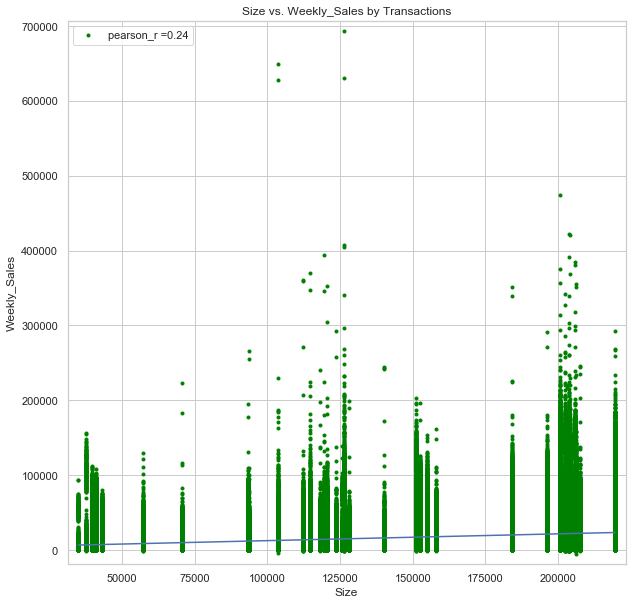

In [28]:
# Plot a linear regression analysis:
plot_linear_reg(df_eda, 'Size', 'Weekly_Sales',
                r_size_sales, 'green', 'Transactions')
plt.show()

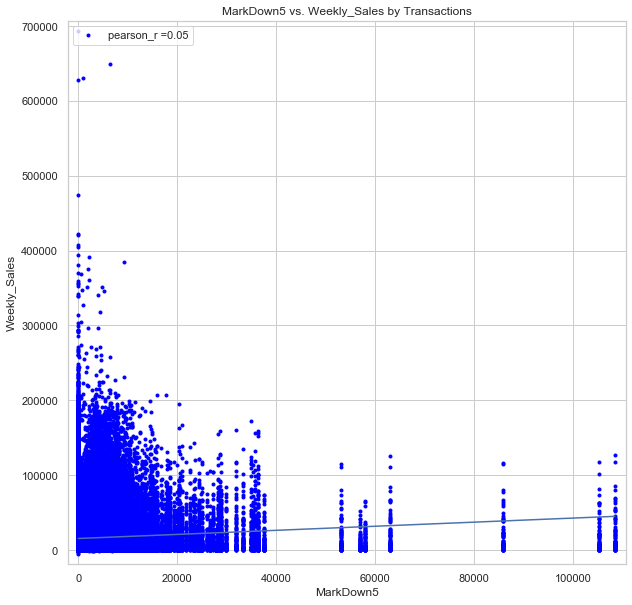

In [29]:
plot_linear_reg(df_eda, 'MarkDown5', 'Weekly_Sales',
                r_md5_sales, 'blue', 'Transactions')
plt.show()

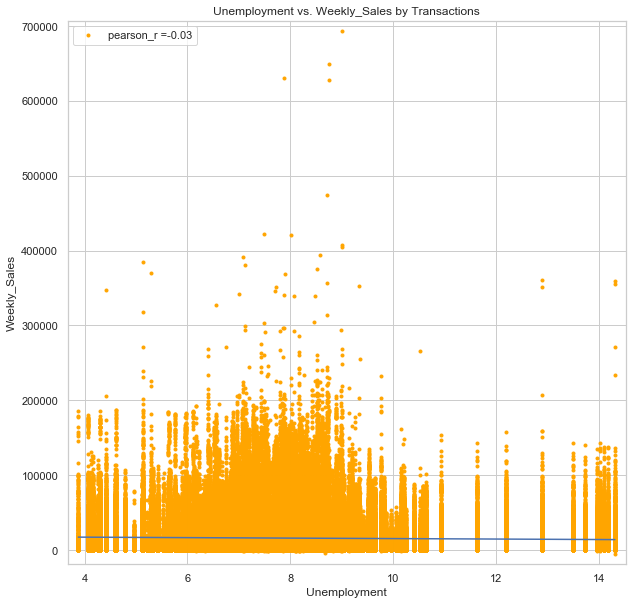

In [30]:
plot_linear_reg(df_eda, 'Unemployment', 'Weekly_Sales',
                r_unemployment_sales, 'orange', 'Transactions')
plt.show()

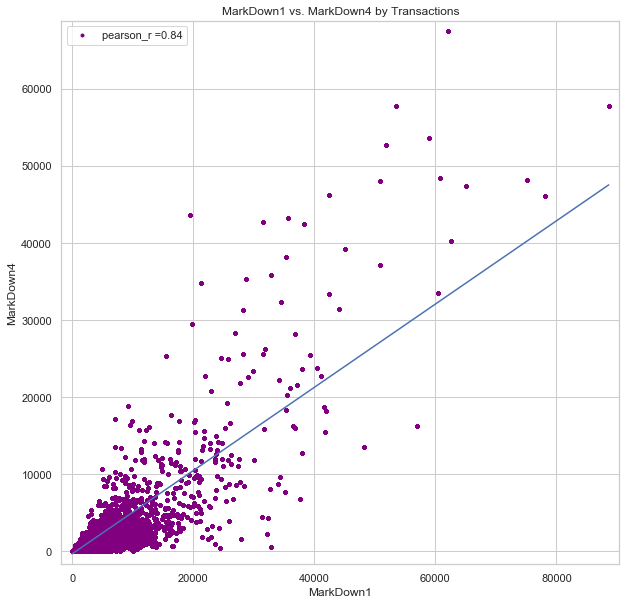

In [31]:
plot_linear_reg(df_eda, 'MarkDown1', 'MarkDown4',
                r_md1_md4, 'purple', 'Transactions')
plt.show()

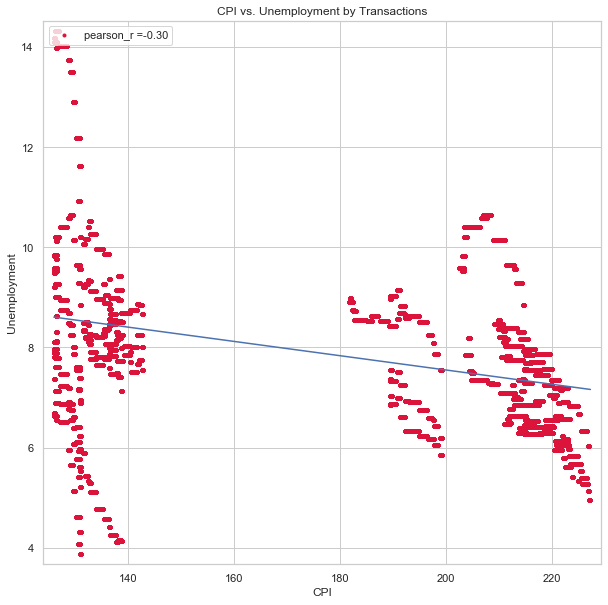

In [32]:
plot_linear_reg(df_eda, 'CPI', 'Unemployment',
                r_cpi_unemployment, 'crimson', 'Transactions')
plt.show()